In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

from itertools import chain

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)'

Using TensorFlow backend.


In [2]:
# entire corpus
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [3]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence      : ", maxLen)
print("Number of words       : ", len(vocabulary))
print("Number of norm. words : ", len(vnorm))
print("Number of POS tags    : ", numClasses)
print("Number of supertags   : ", numSuperClasses)



Longest sentence      :  266
Number of words       :  30300
Number of norm. words :  28223
Number of POS tags    :  32
Number of supertags   :  891


In [4]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


In [145]:

def get_features(string, cat):
    fset = set()

    if (cat == "v"):
        m0 = re.search(r"<(.*)>", string)
        if m0 is not None:
            for item in m0.group(1).split(','):
                fset.add(item)

    m1 = re.search(r"cat=(.*?)[,\]]", string)
    if m1 is not None:
        fset.add(m1.group(1))

    for m2 in re.findall(r"@(.*?)[,\]]", string):
        if not (m2 == "e"):
            fset.add(m2)
    return fset
  

In [298]:
possessive_features = set(['p_P1s', 'p_P2s', 'p_P3s', 'p_P1p', 'p_P2p', 'p_P3p',\
                           'fs_P1s', 'fs_P2s', 'fs_P3s',\
                           's_P1s', 's_P2s', 's_P3s', 's_P1p', 's_P2p', 's_P3p'])

verb_inflection_features = set(['P1s', 'P12s', 'P2s', 'P3s', 'P1p', 'P2p', 'P3p',\
                                'J1s', 'J12s', 'J2s', 'J3s', 'J1p', 'J2p', 'J3p',\
                                'T1s', 'T2s', 'T3s', 'T1p', 'T2p', 'T3p',\
                                'F1s', 'F2s', 'F3s', 'F1p', 'F2p', 'F3p',\
                                'C1s', 'C12s', 'C3s', 'C1p', 'C2p', 'C3p',\
                                'S1s', 'S13s', 'S2s', 'S3s', 'S1p', 'S2p', 'S3p',\
                                #'Y2s', 'Y1p','Y2p', 
                                'G', 'W',\
                                'I1s', 'I12s', 'I3s', 'I1p', 'I2p', 'I3p',\
                                'PS13s', 'PS3','PS2s', 'PS3p',\
                                'PJ12s', 'ST2s',\
                                'K', 'Km', 'Kms', 'Kfs', 'Kmp', 'Kfp'])

inflection_features = set(['ms', 'mp', 'fs', 'fp', '1s', '2s', '3s', '1p', '2p', '3p', '3fs', '3mp', '3fp'])

object_map  = { 'Obj:(cla|sn)':'sn', 'Obj:cla|qcompl|scompl|sinf|sn':'qcompl|scompl|sinf|sn',\
             'Obj:cla|scompl|sn':'scompl|sn', 'Obj:cla|de-sinf|sn':'de-sinf|sn',\
             'Obj:sinf':'sinf', 'Obj:(cla|scompl|sn)':'scompl|sn',\
             'Obj:(cla|scompl|sinf|sn)':'scompl|sinf|sn', 'Obj:(cla|seréc|seréfl|sn)':'sn',\
             'Obj:(à-sinf)':'à-sinf', 'Obj:cla|qcompl|scompl|sn':'qcompl|scompl|sn',\
             'Obj:(scompl|sinf)':'scompl|sinf', 'Obj:(cla|pour-sn|sn)':'pour-sn|sn',\
             'Obj:(cla|de-sinf|scompl|sn)':'de-sinf|scompl|sn', 'Obj:cla|scompl|sinf|sn':'scompl|sinf|sn',\
             'Obj:à-sinf':'à-sinf', 'Obj:(cla|de-sinf|sn|à-sinf)':'de-sinf|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sn)':'qcompl|scompl|sn', 'Obj:(cla|de-sinf|sn)':'de-sinf|sn',\
             'Obj:de-sinf':'de-sinf', 'Obj:(cla|qcompl|scompl|sn|à-sinf)':'qcompl|scompl|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sinf|sn)':'qcompl|scompl|sinf|sn', 'Obj:cla|sn':'sn',\
             'Obj:(cla|de-sinf|qcompl|scompl|sn)':'de-sinf|qcompl|scompl|sn',\
             'Obj:sn':'sn', 'Obj:scompl':'scompl', 'Obj:qcompl':'qcompl', 'Obj:pour-sn':'pour-sn'}


In [323]:
def transform_features(valset):
    features = set()
    for val in valset:
        if val in possessive_features:
            features.add("possessive")
        elif val in verb_inflection_features:
            fts = list(val)
            features = features.union(fts)
        elif val in inflection_features:
            fts = list(val)
            features = features.union(fts)
        elif val == "Obl:en-sn":
            features.add("Obl:(en-sn)")
        elif val == "Att:pour-sa|pour-sn":
            features.add("Att:(pour-sa|pour-sn)")
        elif val.startswith("Suj:"):
            None
        elif val == "imperative" or val == "pers":
            None
        elif val.startswith("Objà:"):
            features.add("Objà")
        elif val.startswith("Objde:"):
            features.add("Objde")
        elif val.startswith("Obj:"):
            tmp = object_map[val]
            lst = tmp.split('|')
            for l in lst:
                features.add("Obj:" + l)
        else:
            features.add(val)
            
    return features

In [324]:

def read_lefff(file):
    vocabulary = set()
    tags = set()
    word_pos_map = {}
    max_word_len = 0
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split("\t")
            w = line[0]
            w = w.replace("æ", "ae")
            w = w.replace("œ", "oe")
            w = w.replace("-_", "-")
            word_len = len(w)
            if (word_len > max_word_len):
                max_word_len = word_len
            wlist = w.split()
            if (len(wlist) == 2):
                w = wlist[0]
                nextfeat == None
                if (wlist[1]).startswith("qu'"):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("que "):
                    nextfeat = "Next:que"
                if (wlist[1] == 'que'):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("d'"):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("de "):
                    nextfeat = "Next:de"
                if (wlist[1] == 'de'):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("à "):
                    nextfeat = "Next:à"
                if (wlist[1] == 'à'):
                    nextfeat = "Next:à"
                if (wlist[1] == 'priori'):
                    nextfeat = "Next:priori"
            elif (len(wlist) == 1):
                nextfeat = None
                
            if (w[0].find("_") == -1 and (len(wlist) == 1) or ((len(wlist) ==2) and (nextfeat is not None))):
                if (w == "c'est-à-dire"):
                    w = "est-à-dire"
                    nextfeat = "Prev:ce"
                pos = line[2]
                features = line[3]
                vocabulary.add(w)
                valset = word_pos_map.get(w)
                if valset is None:
                    valset = set()
                valset.add(pos)
                fts = get_features(features, pos)
                valset = valset.union(fts)
                if nextfeat is not None:
                    valset.add(nextfeat)
                valset = transform_features(valset)
                word_pos_map[w] = valset

    for w in ['capella', 'contratio', 'fortiori', 'latere', 'minima', 'posteriori',  'priori']:
        word_pos_map[w] = set(['priori'])
                
    for key in iter(word_pos_map.keys()):
        word_pos_map[key] = frozenset(word_pos_map[key])
        
    for val in iter(word_pos_map.values()):
        tags.add(val)
        
    return vocabulary, tags, word_pos_map, max_word_len


In [325]:
v, t, wpm, maxWordLen = read_lefff('lefff-ext-3.0.txt')

In [326]:
print(maxWordLen)
print(t)

60
{frozenset({'Objde', '2', 'T', 'CtrlSujObjde', 'v', 'p'}), frozenset({'active', 'K', 'm', 'Objà', 'v', 'impers'}), frozenset({'Obj:scompl', '1', 'Att:sa|sn', 'Obj:sn', 'CtrlObjàObj', 'Obj:sinf', 'CtrlSujObj', 'Obj:de-sinf', 'Objà', 'T', 'v', 'p', 'AttObj'}), frozenset({'G', 'Obj:sn', 'Objà', 'Att:(cla|sn)', 'v'}), frozenset({'Obl:(après-sn)', 'Obj:scompl', 'Obj:à-sinf', 'Obj:sn', 'CtrlObjàObj', 's', '3', 'C', 'Obj:de-sinf', 'CtrlSujObj', 'Objà', 'v'}), frozenset({'Dloc:(de-sn|en)', 'Loc:(loc-sn|y)', 'P', 'CtrlSujObl', 'Obl:(sinf)', 'Objde', 's', '3', 'CtrlSujObjde', 'v', 'être'}), frozenset({'P', 'S', 'nc', 's', 'Objde', '2', 'm', 'Objà', 'v', 'p'}), frozenset({'Obj:qcompl', 'Obj:scompl', 'Obj:sn', 'Obj:sinf', 'CtrlSujObj', 'C', 'Att:(comme-sa|comme-sn|sa|sinf|sn)', 'CtrlObjAtt', 'CompInd', 'v', '1', 'p'}), frozenset({'Obl:(avec-sn)', 'C', '2', 'v', 'p'}), frozenset({'C', 'v', '1', 'p', 'Obl:(sous-sn)'}), frozenset({'s', '3', 'Obj:sn', '1', 'S', 'v'}), frozenset({'Obj:scompl', 'K', 

In [327]:
print(len(t))

9262


In [328]:
print(wpm["Jean"])

frozenset({'s', 'np', 'hum', 'm', 'f'})


In [329]:
print(wpm["est"])

frozenset({'fêtre', 'P', 'nc', 'Att:(sa|à-sinf|à-sn)', 'adj', 's', '3', 'AttSuj', 'auxEtre', 'm', 'Att:(de-sinf|scompl|sn)', 'v'})


In [330]:
print(wpm["été"])

frozenset({'fêtre', 'K', 'nc', 'Att:(sa|à-sinf|à-sn)', 's', 'active', 'AttSuj', 'auxEtre', 'm', 'Att:(de-sinf|scompl|sn)', 'v'})


In [331]:
print(wpm["était"])

frozenset({'fêtre', 'I', 'Att:(sa|à-sinf|à-sn)', 's', '3', 'AttSuj', 'auxEtre', 'Att:(de-sinf|scompl|sn)', 'v'})


In [332]:
print(wpm["faut"])

frozenset({'Obj:scompl', 'P', 'CompSubj', 'Obj:sn', 'Obj:sinf', 'impers', 's', '3', 'Objà', 'v'})


In [333]:
print(wpm["mange"])

frozenset({'P', 'Obj:sn', 'S', 'Y2s', 's', '3', 'v', '1'})


In [334]:
print(wpm["que"])

frozenset({'prel', 'pro_acc', 'que', 'pri', 'que_restr'})


In [ ]:
print(wpm["qu'"])

In [ ]:
print(wpm["priori"])

In [ ]:
print(wpm["importe"])

In [ ]:
print(len(v))

In [335]:
fset = set()
for frozen in t:
    for f in frozen:
        fset.add(f)
print(fset)
print(len(fset))
outFeatures = len(fset)+1

{'prel', 'Obl:(pour-sn)', 'Obj:scompl', 'cla', 'clar', 'ce', 'Y2p', 'Obl:(pour-sinf|sinf)', 'AttObj', 'Att:(pour-sa|pour-sn)', '3ms', 'Obl2:(par-sn)', 'Obl:(contre-sn|sur-sn)', 'CtrlObjObl', 'clneg', 'advneg', 'Att:(cla|sn)', 'parento', 'poncts', 'Obl:(contre-sn)', 'pseudo-en_possible', 'C', 'ACompSubj', 'Loc:(dans-sn|y)', 'Loc:(cll|loc-sn)', 'Loc:(y|à-sn)', 'Att:(comme-sa|comme-sn|sa|sinf|sn)', 'se_moyen', 'Obl:(par-sn)', 'Obl:(dans-sn)', 'Obl:(sous-sn)', 'Obl:(après-sn)', 'np', 'n', 'CompSubj', 'Obl2:(contre-sn)', 'pro_loc', 'Next:priori', 'Obj:sinf', 'Att:(sn)', 'Obl:(avec-sn)', 'adj', 'hum', 'CtrlSujObj', 'Next:que', 'cf', 'T', 'cfi', 'time', 'adv', 'Loc:(loc-sn|sinf|y)', 'cll', 'ponctw', 'cln', 'P', 'G', 'epsilon', 'parentf', 'être', 'Obl2:(loc-sn)', 'CtrlSujLoc', 'Obl:(sur-sn)', 'advm', 'active', 'poss', 'pri', 'I', 'prep', 'cld', 'Att:de-sa|de-sn', 'Obl:(à-sinf)', 'auxAvoir', 'Loc:(sur-sn)', 'sym', 'coo', 'CtrlObjObjde', 'Loc:loc-sn|sinf|y', 'CtrlSujAtt', 'Obl:(pour-sinf)', 'clg

In [336]:
feature_to_integer, integer_to_feature = indexify(fset)

In [337]:
print(X[0])
print(integer_to_feature[140])

['Lyonnaise-Dumez', 'vient', "d'", 'hispaniser', 'sa', 'filiale', 'espagnole', 'et', "d'", 'étendre', 'ses', 'participations', 'en', 'Espagne', ',', 'tout', 'en', 'resserrant', 'ses', 'liens', 'avec', 'la', 'Caixa', ',', 'première', 'caisse', "d'", 'épargne', 'espagnole', 'et', "l'", 'un', 'des', 'premiers', 'établissements', 'financiers', 'de', 'la', 'péninsule', 'ibérique', ',', 'à', 'laquelle', 'elle', 'est', 'liée', 'depuis', 'longtemps', 'dans', 'la', 'Société', 'générale', 'des', 'eaux', 'de', 'Barcelone', '(', 'SGAB', ')', ',', 'premier', 'groupe', 'espagnol', 'de', 'services', '(', 'la', 'Caixa', 'détient', 'aussi', '2', '%', 'du', 'capital', 'de', 'Lyonnaise-Dumez', ')', '.']
Obj:de-sinf


In [338]:
def get_characters(vocabulary):

    characters = set(['^', 'Û', '³', 'Ê', '<BOS>', '<BOW>', '<EOW>', '<EOS>', '<UNK>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    for word in vocabulary:
        clist = list(word)
        for char in clist:
            characters.add(char)
    
    remove = set(['|', '«', '»', 'µ', '§', 'þ', 'ø', '_', '¯', 'ð', 'æ', '~', '©', '@', '~'])
    
    return characters - remove

In [339]:
characters = get_characters(v)
print(characters)
print(len(characters))

maxChars = len(characters)

character_to_integer, integer_to_character = indexify(characters)

{'ì', '<BOW>', 'õ', '°', 'Ê', 'a', 'O', '<BOS>', '<EOS>', 'º', '/', ';', '5', 'x', 'j', 'o', '9', 'C', 'Y', 'n', 'E', 'Á', 'T', 'à', '<', 'P', '4', 'X', 'G', 'â', '½', 'k', 'Û', "'", 'D', 'ê', 't', '³', 'í', 'M', 'ü', '0', 'R', 'U', '8', 'I', '?', ')', '!', 'h', 'î', '+', 'È', 'À', 'ö', 'å', '<EOW>', '=', '1', 'p', '<UNK>', 'ë', 'W', 'i', 'J', 'ô', 'ñ', 'V', 'l', '$', 'ä', '^', 'è', 'e', 'ç', ':', 'S', 'á', 'Z', 'w', 'v', 'g', 'Q', 'f', 'm', '6', 'é', '%', 'q', 'u', 'r', ',', 'd', '2', 'ï', 'É', 'c', 'Å', '[', 'Ç', '*', 'H', 'ã', '-', '(', 'û', 'b', 'z', '²', 'N', '"', 'F', 'L', 'B', 'ò', '>', 'ú', ']', 'ù', 'y', 'K', '.', 'A', 'Î', 'ó', '7', 's', '3', '&', '±'}
130


In [340]:
mapping = {}

mapping["="] = set(['math', 'infix'])
mapping["<"] = set(['math', 'infix'])
mapping[">"] = set(['math', 'infix'])


mapping["+"] = set(['math', 'infix'])
mapping["*"] = set(['math', 'infix'])
mapping["±"] = set(['math', 'prefix'])
mapping["°"] = set(['math', 'postfix'])
mapping["º"] = set(['math', 'postfix'])
mapping["²"] = set(['math', 'postfix'])
mapping["³"] = set(['math', 'postfix'])



mapping["0"] = set(['9'])
mapping["1"] = set(['9'])
mapping["2"] = set(['9'])
mapping["3"] = set(['9'])
mapping["4"] = set(['9'])
mapping["5"] = set(['9'])
mapping["6"] = set(['9'])
mapping["7"] = set(['9'])
mapping["8"] = set(['9'])
mapping["½"] = set(['9'])

mapping["A"] = set(['a', 'maj'])
mapping["B"] = set(['b', 'maj'])
mapping["C"] = set(['c', 'maj'])
mapping["D"] = set(['d', 'maj'])
mapping["E"] = set(['e', 'maj'])
mapping["F"] = set(['f', 'maj'])
mapping["G"] = set(['g', 'maj'])
mapping["H"] = set(['h', 'maj'])
mapping["I"] = set(['i', 'maj'])
mapping["J"] = set(['j', 'maj'])
mapping["K"] = set(['k', 'maj'])
mapping["L"] = set(['l', 'maj'])
mapping["M"] = set(['m', 'maj'])
mapping["N"] = set(['n', 'maj'])
mapping["O"] = set(['o', 'maj'])
mapping["P"] = set(['p', 'maj'])
mapping["Q"] = set(['q', 'maj'])
mapping["R"] = set(['r', 'maj'])
mapping["S"] = set(['s', 'maj'])
mapping["T"] = set(['t', 'maj'])
mapping["U"] = set(['u', 'maj'])
mapping["V"] = set(['v', 'maj'])
mapping["W"] = set(['w', 'maj'])
mapping["X"] = set(['x', 'maj'])
mapping["Y"] = set(['y', 'maj'])
mapping["Z"] = set(['z', 'maj'])

mapping["á"] = set(['a', 'aigu'])
mapping["à"] = set(['a', 'grave'])
mapping["ä"] = set(['a', 'uml'])
mapping["â"] = set(['a', 'circ'])
mapping["ã"] = set(['a', 'tilde'])
mapping["å"] = set(['a'])

mapping["ç"] = set(['c', 'cedil'])

mapping["é"] = set(['e', 'aigu'])
mapping["è"] = set(['e', 'grave'])
mapping["ê"] = set(['e', 'circ'])
mapping["ë"] = set(['e', 'uml'])


mapping["ï"] = set(['i', 'uml'])
mapping["í"] = set(['i', 'aigu'])
mapping["î"] = set(['i', 'circ'])
mapping["ì"] = set(['i', 'grave'])

mapping["ñ"] = set(['n', 'tilde'])

mapping["ö"] = set(['o', 'uml'])
mapping["ó"] = set(['o', 'aigu'])
mapping["õ"] = set(['o', 'tilde'])
mapping["ô"] = set(['o', 'circ'])
mapping["ò"] = set(['o', 'grave'])
mapping["ò"] = set(['o', 'grave'])


mapping["û"] = set(['u', 'circ'])
mapping["ú"] = set(['u', 'aigu'])
mapping["ù"] = set(['u', 'grave'])
mapping["ü"] = set(['u', 'uml'])

mapping["Á"] = set(['a', 'maj', 'aigu'])
mapping["À"] = set(['a', 'maj', 'grave'])
mapping["Å"] = set(['a', 'maj'])

mapping["Ç"] = set(['c', 'maj', 'cedil'])

mapping["È"] = set(['e', 'maj', 'grave'])
mapping["É"] = set(['e', 'maj', 'aigu'])
mapping["Ê"] = set(['e', 'maj', 'circ']) 

mapping["Î"] = set(['i', 'maj', 'circ'])

mapping["Û"] = set(['u', 'maj', 'circ'])



In [341]:
def compute_symset (characters, mapping):
    symset = set()
    for c in characters:
        try:
            syms = mapping[c]
            symset = symset.union(syms)
        except:
            symset.add(c)
    return symset

In [342]:
sset = compute_symset(characters, mapping)
print(sset)

maxCharFeat = len(sset)+1
print(len(sset))

print(mapping['+'])

{'circ', '<BOW>', 'grave', '<UNK>', '[', 'aigu', 'i', '-', '(', 'b', 'l', 'k', '$', 'z', 'a', '<BOS>', '^', "'", '<EOS>', 't', 'e', 'uml', ':', '/', 'maj', ';', 'tilde', '"', 'w', 'x', 'v', 'g', '?', 'j', 'infix', ')', 'f', '!', ']', 'h', 'o', '9', 'prefix', 'm', 'math', 'postfix', 'y', 'n', 'cedil', '.', '%', 'q', 'u', 'r', ',', 's', 'd', '<EOW>', '&', 'p', 'c'}
61
{'math', 'infix'}


In [343]:
def char_to_charfeatures (char, mpg, symbset):
    try:
        feats = mpg[char]
    except:
        if (char in symbset):
            feats = set([char])
        else:
            feats = set(['<UNK>'])
    
    return feats

In [344]:
char_to_charfeatures("A", mapping, sset)

{'a', 'maj'}

In [345]:
charf_to_integer, integer_to_charf = indexify(sset)

In [346]:
charf_to_integer.keys()

dict_keys(['circ', '<BOW>', 'grave', '<UNK>', '[', 'aigu', 'i', '-', '(', 'b', 'l', 'k', '$', 'z', 'a', '<BOS>', '^', "'", '<EOS>', 't', 'e', 'uml', ':', '/', 'maj', ';', 'tilde', '"', 'w', 'x', 'v', 'g', '?', 'j', 'infix', ')', 'f', '!', ']', 'h', 'o', '9', 'prefix', 'm', 'math', 'postfix', 'y', 'n', 'cedil', '.', '%', 'q', 'u', 'r', ',', 's', 'd', '<EOW>', '&', 'p', 'c'])

In [347]:
def char_to_one_hot(char, mpg, c_to_in, symbset, mcf):
    fset = char_to_charfeatures(char, mpg, symbset)
    numf = len(fset)
    
    tmp = np.zeros(numf)
    index = 0
    for item in fset:
        tmp[index] = c_to_in[item]
        index = index + 1
    Y = to_categorical(tmp, mcf)
    return np.sum(Y,axis=0)
   

In [348]:
Y0 = char_to_one_hot("A", mapping, charf_to_integer, sset, maxCharFeat)

print(Y0)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [349]:
transform = np.zeros((maxChars+1, maxCharFeat))
for char, i in character_to_integer.items():
    transform[i] = char_to_one_hot(char, mapping, charf_to_integer, sset, maxCharFeat)
    
np.shape(transform)

(131, 62)

In [350]:
def word_to_one_hot(word, mpg, c_to_in, symbset, mcf, bos, eos):
    ls = list(word)
    length = len(ls)+2
    end = length - 1
    Y = np.zeros((length,mcf))
    if bos:
        Y[0] = char_to_one_hot('<BOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[0] = char_to_one_hot('<BOW>', mpg, c_to_in, symbset, mcf)
    if eos:
        Y[end] = char_to_one_hot('<EOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[end] = char_to_one_hot('<EOW>', mpg, c_to_in, symbset, mcf)

    for i in range(0,end-1):
        Y[i+1] = char_to_one_hot(ls[i], mpg, c_to_in, symbset, mcf)
        
    return Y

In [351]:
Jean = word_to_one_hot('Jean', mapping, charf_to_integer, sset, maxCharFeat, True, True)
print(np.shape(Jean))
print(Jean)

(6, 62)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [352]:
totalWords = 0
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        totalWords = totalWords + 1
  
print(totalWords)

264432


In [353]:
def compute_total_words(word_matrix):
  
    tw = 0
    
    for i in range(len(word_matrix)):
        for j in range(len(word_matrix[i])):
             tw = tw + 1

    return tw


In [354]:
def word_matrix_to_charint_matrix(word_matrix, max_chars):
 
    total_words = compute_total_words(word_matrix)
    
    X_charint = np.zeros((total_words,max_chars))
    
    xindex = 0

    # iterate over sentences in input matrix
    for i in range(len(word_matrix)):
        end = len(word_matrix[i])
        # iterater over words in sentences
        for j in range(len(word_matrix[i])):
            charslist = list(word_matrix[i][j])
            # add beginning/end of word/sentence tags to word
            if (j == 0):
                X_charint[xindex][0] = character_to_integer['<BOS>']
            else:
                X_charint[xindex][0] = character_to_integer['<BOW>']
            if (j == end-1):
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOS>']
            else:
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOW>']
            for c in range(len(charslist)):
                d = c + 1
                char = charslist[c]
                try:
                    X_charint[xindex][d] = character_to_integer[char]
                except:
                    # warn when unknown character is encountered
                    print("Unknown character: ", end='')
                    print(i, end=' ')
                    print(charslist)
            # increase word counter
            xindex = xindex + 1
    return X_charint

In [355]:
X_charint_input = word_matrix_to_charint_matrix(X_train, maxChars)

In [356]:
print(np.shape(X_charint_input))
print(X_charint_input[5])

(264432, 130)
[  2.  92.  57.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [357]:
print(X_train[397])
print(character_to_integer['U'])

['-', '^', 'Reuters', 'Doctoring', 'Photos', 'from', 'Beirut', '?']
44


In [358]:
# compensate for some missing words in lefff

def outword_mapping(word):
    lword = word.lower()
    if lword == "auquel":
        return set(['à', 'lequel'])
    if lword == "auxquels":
        return set(['à', 'lesquels'])
    if lword == "auxquelles":
        return set(['à', 'lesquelles'])
    if lword == "aux":
        return set(['à', 'les'])
    if lword == "duquel":
        return set(['de', 'lequel'])
    if lword == "desquels":
        return set(['des', 'lesquels'])
    if lword == "desquelles":
        return set(['des', 'lesquelles'])
    if lword == "des":
         return set(['de', 'les'])
    if lword == "au":
        return set(['à', 'le'])
    if lword == "du":
         return set(['de', 'le'])
    if lword == "deçà":
         return set(['dessous'])
    if word == "Etat":
         return set(["état"])
    if len(word) == 1 and word.isupper:
        return set(['Alpha'])
    if is_numeral(word):
        return set(["dix-sept"])
    if word == "CNRS":
        return set(['centre'])
    if word == "CRS":
        return set(['centre'])
    if word == "CSA":
        return set(['compagnie'])
    if word == "EDF":
        return set(['électricité'])
    if word == "ANPE":
        return set(['agence'])
    if word == "ONG" or word == "ONU":
        return set(['organisation'])
    if word == "AOC":
        return set(['appelation'])
    if word == "ALENA":
        return set(['accord'])
    if word == "ASSEDIC":
        return set(['association'])
    if word == "PIB":
        return set(['produit'])
    if word == "SMIC":
        return set(['salaire'])


    return set([word])
       

In [359]:
def wordf_to_one_hot(word, outword_mapping, wpm, f_to_in, fset, outf):
    wordset = outword_mapping(word)
    featureset = set()
    for word in wordset:
        if word in wpm.keys():
            featureset = featureset.union(wpm[word])
        else:
            wordl = word.lower()
            if wordl in wpm.keys():
                featureset = featureset.union(wpm[wordl])
            else:
                print("Unknown: ", word)
                featureset = set()
            
    length = len(featureset)
#    Y = np.zeros((length,outf))

    i = 0
    tmp = np.zeros(len(featureset))
    for f in featureset:
        tmp[i] = f_to_in[f]
        i = i + 1
    Y = to_categorical(tmp, outf)

    return np.sum(Y,axis=0)

In [360]:
def normalize_capitals(word):
    word = word.replace("É", "E")
    word = word.replace("Î", "I")
        

In [361]:
vector = wordf_to_one_hot("aux", outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(np.shape(vector))
print(vector)
print(vector[0])

(173,)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
0.0


In [362]:
print(X_train[0][0])
vec = wordf_to_one_hot(X_train[0][0], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(vec)

Des
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [363]:
def compute_word_targets(X, outword_mapping, wpm, feature_to_integer, fset, outFeatures):

    total_words = compute_total_words(X)
    Y = np.zeros((total_words,outFeatures))

    yindex = 0

    for i in range(len(X)):
        for j in range(len(X[i])):
            Y[yindex] = wordf_to_one_hot(X[i][j], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            yindex = yindex + 1

    return Y

In [364]:
Y_train = compute_word_targets(X_train, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  CBV
Unknown:  Guintoli
Unknown:  ÉTATS-UNIS
Unknown:  Popi
Unknown:  Bayard
Unknown:  HLM
Unknown:  TVA
Unknown:  Doubin
Unknown:  Jean-Louis
Unknown:  Pétriat
Unknown:  FNAC
Unknown:  Ruymbeke
Unknown:  BCCI
Unknown:  Mahfouz
Unknown:  bank
Unknown:  Jean-Yves
Unknown:  Chamard
Unknown:  RPR
Unknown:  UDF
Unknown:  UDC
Unknown:  Etats
Unknown:  Guinée-Equatoriale
Unknown:  Sierra-Léone
Unknown:  Pronasol
Unknown:  M3
Unknown:  Bundesbank
Unknown:  UNIM
Unknown:  Schlesinger
Unknown:  Bundesbank
Unknown:  PS
Unknown:  Etats
Unknown:  Balmary
Unknown:  OCDE
Unknown:  SME
Unknown:  PNB
Unknown:  Etats
Unknown:  RPR
Unknown:  UDF
Unknown:  rétrocommissions
Unknown:  Strauss-Kahn
Unknown:  CNPF
Unknown:  UPA
Unknown:  RMI
Unknown:  Jean-Pierre
Unknown:  Jean-Pierre
Unknown:  PAP
Unknown:  Lodz
Unknown:  Bydgoszcz
Unknown:  Wroclaw
Unknown:  Zielona-Gora
Unknown:  Szczecin
Unknown:  Bérégovoy
Unknown:  Gomez
Unknown:  Eisswein
Unknown:  Thomson
Unknown:  Elettrofinanziaria
Unknown

Unknown:  AGF
Unknown:  Worms
Unknown:  BNP
Unknown:  Banexi
Unknown:  BTF
Unknown:  Gbm.H
Unknown:  Sochaux-Montbéliard
Unknown:  Louise-Yvonne
Unknown:  Casetta
Unknown:  RPR
Unknown:  Curien
Unknown:  Mellick
Unknown:  Bull
Unknown:  Nec
Unknown:  GPL
Unknown:  AEG
Unknown:  Lagardère
Unknown:  TF
Unknown:  zig-Zag
Unknown:  Bouygues
Unknown:  DEFICIT
Unknown:  UNEDIC
Unknown:  RDA
Unknown:  Joffre
Unknown:  Who's
Unknown:  next
Unknown:  m2
Unknown:  SCA
Unknown:  SCA
Unknown:  Pelège
Unknown:  Electronique
Unknown:  Bundesbank
Unknown:  CAC
Unknown:  Sirven
Unknown:  Elf
Unknown:  Dumas
Unknown:  L.
Unknown:  C.
Unknown:  Waïkiki
Unknown:  Jean-Louis
Unknown:  Guigou
Unknown:  vingt-huit
Unknown:  MFI
Unknown:  Furniture
Unknown:  group
Unknown:  Bongrain
Unknown:  ULN
Unknown:  Besnier
Unknown:  RVI
Unknown:  Mercedes-Benz
Unknown:  Eltsine
Unknown:  Fath
Unknown:  OLP
Unknown:  Zeid
Unknown:  Wehbé
Unknown:  OLP
Unknown:  Joumblatt
Unknown:  PSP
Unknown:  City
Unknown:  Oxbridge

Unknown:  Debatisse
Unknown:  Candia
Unknown:  Yoplait
Unknown:  Guison
Unknown:  Bundesbank
Unknown:  surteint
Unknown:  surpiquer
Unknown:  denim
Unknown:  San-Francisco
Unknown:  Groupama
Unknown:  ZDS
Unknown:  Koweit
Unknown:  Perot
Unknown:  brocca
Unknown:  Armenia
Unknown:  Hyundai
Unknown:  BSN
Unknown:  New-York
Unknown:  Vergez
Unknown:  Perigot
Unknown:  Guillen
Unknown:  UIMM
Unknown:  FMI
Unknown:  1er
Unknown:  CSG
Unknown:  CNAM
Unknown:  RSF
Unknown:  immobilier-logement
Unknown:  ROME
Unknown:  Eltsine
Unknown:  Jose
Unknown:  Aznar
Unknown:  directeur-fondateur
Unknown:  Lobry
Unknown:  lavanges
Unknown:  Ruset
Unknown:  CCR
Unknown:  EPIC
Unknown:  Balladur
Unknown:  caméramen
Unknown:  Dupart
Unknown:  TD
Unknown:  OFP
Unknown:  COSEC
Unknown:  IUT
Unknown:  nord-américaines
Unknown:  United
Unknown:  Dupuit
Unknown:  Cournot
Unknown:  chauffeur-routier
Unknown:  onuso-américaine
Unknown:  Jouve
Unknown:  Lambiotte
Unknown:  Saint-Etienne
Unknown:  Marie-Jo
Unknown

Unknown:  3e
Unknown:  Delors
Unknown:  Lagardère
Unknown:  Stern
Unknown:  Northern
Unknown:  Telecom
Unknown:  Pirelli
Unknown:  Lagardère
Unknown:  Ufima
Unknown:  Smer
Unknown:  Jacquin
Unknown:  Isle-sur-le-Doubs
Unknown:  SED
Unknown:  Just
Unknown:  it
Unknown:  Andre
Unknown:  Agassi
Unknown:  Eastern
Unknown:  Economic
Unknown:  Hongkong
Unknown:  Silla
Unknown:  Jean-Michel
Unknown:  Bloch-lainé
Unknown:  Worms
Unknown:  UAP
Unknown:  franco-allemand
Unknown:  Etats
Unknown:  Kohl
Unknown:  LUXEMBOURG
Unknown:  Bagnères
Unknown:  Bigorre
Unknown:  FMI
Unknown:  Etats
Unknown:  Benattia
Unknown:  Grabis
Unknown:  Abdel
Unknown:  Rhazza
Unknown:  Ledoucin
Unknown:  n88-70
Unknown:  CBV
Unknown:  Moody's
Unknown:  downgrading
Unknown:  Sombart
Unknown:  Weiss
Unknown:  Krezdorn
Unknown:  PUF
Unknown:  Corradetti
Unknown:  SNEC
Unknown:  devis-type
Unknown:  cuisinistes
Unknown:  devis-type
Unknown:  CNJA
Unknown:  Genève
Unknown:  Montréal
Unknown:  NEC
Unknown:  GATT
Unknown:  

Unknown:  Twain
Unknown:  Champs-Elysées
Unknown:  Denormandie
Unknown:  Edinter
Unknown:  Jean-Pierre
Unknown:  Guéno
Unknown:  Pasqua
Unknown:  RTL
Unknown:  Duport
Unknown:  CPI
Unknown:  Île-de-France
Unknown:  Vilaseca
Unknown:  Korauto
Unknown:  Bourget
Unknown:  campo
Unknown:  roues-pelles
Unknown:  Ruymbeke
Unknown:  Xavière
Unknown:  Simeoni
Unknown:  Talancé
Unknown:  CCSDN
Unknown:  Claude-Annick
Unknown:  Tissot
Unknown:  Chugbo
Unknown:  Torre
Unknown:  SAR
Unknown:  Poullain
Unknown:  Jean-Claude
Unknown:  Méry
Unknown:  RPR
Unknown:  Ynetnews
Unknown:  Soum
Unknown:  Aspè
Unknown:  Di
Unknown:  Rupo
Unknown:  Dusseldorf
Unknown:  CNTS
Unknown:  ULN
Unknown:  Smith
Unknown:  21e
Unknown:  336e
Unknown:  Souain
Unknown:  Halbwax
Unknown:  raccordables
Unknown:  OFCE
Unknown:  Agnelli
Unknown:  Bergons
Unknown:  Zelnick
Unknown:  Virgin
Unknown:  Doubin
Unknown:  FAO
Unknown:  Sopalin
Unknown:  Kimberly-Clark
Unknown:  General
Unknown:  Motors
Unknown:  Thomson
Unknown:  G

Unknown:  Bundesbank
Unknown:  Lang
Unknown:  franco-allemande
Unknown:  Jules-Romains
Unknown:  INA
Unknown:  FNE
Unknown:  vingt-six
Unknown:  vingt-six
Unknown:  vingt-six
Unknown:  immobilier-logement
Unknown:  appelation
Unknown:  Trasgo
Unknown:  ejidos
Unknown:  Imbot
Unknown:  Imbot
Unknown:  Kravtchouk
Unknown:  XIX
Unknown:  Agnelli
Unknown:  Dachaud
Unknown:  Cesano
Unknown:  Rohou
Unknown:  COB
Unknown:  Dumas
Unknown:  Epreuve
Unknown:  Lafon
Unknown:  Bundesbank
Unknown:  Tietmeyer
Unknown:  Edouard
Unknown:  Balladur
Unknown:  Giscard
Unknown:  CEE
Unknown:  AMB
Unknown:  Kaske
Unknown:  Fondiaria
Unknown:  refranchir
Unknown:  Northern
Unknown:  Telecom
Unknown:  Game
Unknown:  Sega
Unknown:  Nintendo
Unknown:  antibloquants
Unknown:  notionnel
Unknown:  Chérèque
Unknown:  Luchon
Unknown:  INSEE
Unknown:  Rmistes
Unknown:  FMI
Unknown:  Talancé
Unknown:  Ruymbeke
Unknown:  billettiste
Unknown:  OCDE
Unknown:  LONDRES
Unknown:  Karlsruhe
Unknown:  Limbourg
Unknown:  1er


Unknown:  Pittsburgh
Unknown:  Jones
Unknown:  ZDS
Unknown:  PNB
Unknown:  Roddick
Unknown:  conjoncturistes
Unknown:  CBV
Unknown:  contraventionnelles
Unknown:  Exupéry
Unknown:  Jules-Romains
Unknown:  CATE
Unknown:  très-considérable
Unknown:  Sibille
Unknown:  popiwek
Unknown:  Balcerowicz
Unknown:  Schweitzer
Unknown:  Barrau
Unknown:  Kuo
Unknown:  CEE
Unknown:  qualité-prix
Unknown:  Jean-Noël
Unknown:  Kapferer
Unknown:  HEC
Unknown:  OPCVM
Unknown:  COB
Unknown:  OPCVM
Unknown:  Vendôme
Unknown:  UAP
Unknown:  Bruxelles-Lambert
Unknown:  OAT
Unknown:  BTAN
Unknown:  contrario
Unknown:  Time
Unknown:  Levin
Unknown:  Perraudin
Unknown:  Wang
Unknown:  The
Unknown:  European
Unknown:  COB
Unknown:  LRM
Unknown:  H.
Unknown:  Vuong
Unknown:  Indochine
Unknown:  XVII
Unknown:  No.
Unknown:  COMECON
Unknown:  Angiox
Unknown:  bivalirudine
Unknown:  hirudines
Unknown:  Angiox
Unknown:  Genève
Unknown:  Fès
Unknown:  Tchécoslovaquie
Unknown:  UNEDIC
Unknown:  marchandise-étalon
Unkn

Unknown:  Bayard
Unknown:  Hongkong
Unknown:  TVA
Unknown:  Comédie-Française
Unknown:  Soixante-quinze
Unknown:  Los
Unknown:  Mochis
Unknown:  Etats
Unknown:  OEA
Unknown:  OUA
Unknown:  peronnellement
Unknown:  bivalirudine
Unknown:  Pellerin
Unknown:  DGCCRF
Unknown:  Thomson
Unknown:  CSF
Unknown:  Altus
Unknown:  Quillery
Unknown:  Guerra
Unknown:  Tarcy
Unknown:  reformatage
Unknown:  TF
Unknown:  Sagem
Unknown:  Ménétrez
Unknown:  Souain
Unknown:  en-dessous
Unknown:  saint-Gobain
Unknown:  CCF
Unknown:  Kleinwort
Unknown:  Gian-franco
Unknown:  Nocivelli
Unknown:  Elfi
Unknown:  TEM
Unknown:  Satam
Unknown:  Pariente
Unknown:  Naf-Naf
Unknown:  repreneurs
Unknown:  NICOLAS
Unknown:  GUILBERT
Unknown:  Milken
Unknown:  Securities
Unknown:  and
Unknown:  Exchange
Unknown:  COB
Unknown:  Dutoya
Unknown:  Thatcher
Unknown:  Modrow
Unknown:  STASI
Unknown:  RFA
Unknown:  Transdev
Unknown:  PSA-Peugeot-Citroën
Unknown:  CUT
Unknown:  Pasqua
Unknown:  Berlusconi
Unknown:  Marie-Noëll

Unknown:  Metal
Unknown:  Research
Unknown:  Bohême-Moravie
Unknown:  Etats
Unknown:  BBC
Unknown:  BBC
Unknown:  World
Unknown:  Poperen
Unknown:  Lienemann
Unknown:  Vergèze
Unknown:  Gorbatchev
Unknown:  PC
Unknown:  valses-hésitations
Unknown:  RDA
Unknown:  CNCC
Unknown:  BBC
Unknown:  Elargir
Unknown:  BBC
Unknown:  Chicago
Unknown:  Zenith
Unknown:  Bull
Unknown:  Naf
Unknown:  Naf
Unknown:  CIATER
Unknown:  Cusiana
Unknown:  Cupiaga
Unknown:  Bundesbank
Unknown:  RMI
Unknown:  Economie
Unknown:  INSEE
Unknown:  RMI
Unknown:  Laske
Unknown:  État-voyou
Unknown:  Denoël
Unknown:  anglo-néerlandais
Unknown:  Ponthieux
Unknown:  Echos
Unknown:  Marboré
Unknown:  Berlusconi
Unknown:  coca-cola
Unknown:  Mercosur
Unknown:  sud-américains
Unknown:  Jack-Yves
Unknown:  Bohbot
Unknown:  Dominati
Unknown:  SAN-FRANCISCO
Unknown:  Evalué
Unknown:  Bongrain
Unknown:  Besnier
Unknown:  UAP
Unknown:  Nordstern
Unknown:  Colonia
Unknown:  FRANCFORT
Unknown:  Procopio
Unknown:  Neto
Unknown:  

Unknown:  Bérégovoy
Unknown:  Bérégovoy
Unknown:  Sumitomo
Unknown:  Conforama
Unknown:  vingt-six
Unknown:  Charasse
Unknown:  GATT
Unknown:  Punta-del-Este
Unknown:  PAC
Unknown:  Desfossés
Unknown:  H.
Unknown:  H.
Unknown:  Bonn
Unknown:  Lagardère
Unknown:  Bertelsmann
Unknown:  top-down
Unknown:  Thomson
Unknown:  CSF
Unknown:  Wang
Unknown:  Sirven
Unknown:  Kwan
Unknown:  Conforama
Unknown:  Pinault
Unknown:  Elmalek
Unknown:  Mobis
Unknown:  Québecor
Unknown:  Montréal
Unknown:  Graficas
Unknown:  TIPP
Unknown:  ULN
Unknown:  GUF
Unknown:  PNB
Unknown:  Trèves
Unknown:  Bundesbank
Unknown:  Lafayette
Unknown:  Legrand
Unknown:  Kontavill
Unknown:  Hetzel
Unknown:  Miot
Unknown:  Jean-Noël
Unknown:  Kapferer
Unknown:  OTAN
Unknown:  CEI
Unknown:  General
Unknown:  GSA
Unknown:  Zenith
Unknown:  arrière-petits-enfants
Unknown:  repreneur
Unknown:  The
Unknown:  Telegraph
Unknown:  Maistre
Unknown:  Liliane
Unknown:  Bettencourt
Unknown:  JDD
Unknown:  Maastricht
Unknown:  Lajoin

Unknown:  Three
Unknown:  Ménez
Unknown:  46e
Unknown:  M'Vila
Unknown:  48e
Unknown:  Valbuena
Unknown:  70e
Unknown:  Gorby
Unknown:  Éric
Unknown:  Halphen
Unknown:  21e
Unknown:  Creeks
Unknown:  Stromboni
Unknown:  KLM
Unknown:  Economica
Unknown:  F.
Unknown:  AIEJ
Unknown:  CNPF
Unknown:  redécoupage
Unknown:  Bérégovoy
Unknown:  Arthuis
Unknown:  AC
Unknown:  Perot
Unknown:  Rocard
Unknown:  Indosuez
Unknown:  COURCELLES-LES-MONTBELIARD
Unknown:  Duramé
Unknown:  Gaudillère
Unknown:  Lamotte
Unknown:  Scalbert
Unknown:  Dupont
Unknown:  Jean-Paul
Unknown:  Escande
Unknown:  Madinier
Unknown:  accroitre
Unknown:  Eiffel
Unknown:  Fiorentina
Unknown:  Lazio
Unknown:  Bf.G
Unknown:  AMB
Unknown:  RPR
Unknown:  LAGOS
Unknown:  franco-française
Unknown:  rhodanien
Unknown:  Bundesbank
Unknown:  Seydoux
Unknown:  CLT
Unknown:  Lyon-Libération
Unknown:  Jean-Claude
Unknown:  Méry
Unknown:  sous-traitantes
Unknown:  réalignement
Unknown:  Thieblin
Unknown:  Télécom
Unknown:  group
Unkn

Unknown:  linéen
Unknown:  Staedelin
Unknown:  Palazzi
Unknown:  Constantinople
Unknown:  Bosphore
Unknown:  1er
Unknown:  Éric
Unknown:  Halphen
Unknown:  FMI
Unknown:  Mourmelon
Unknown:  1er
Unknown:  DIDIER
Unknown:  Lotharingie
Unknown:  CIP
Unknown:  BELGIQUE
Unknown:  Pinault-Printemps
Unknown:  ISBN
Unknown:  of
Unknown:  Credit
Unknown:  and
Unknown:  BCCI
Unknown:  OCDE
Unknown:  Mc
Unknown:  Guffey
Unknown:  Grand-Prairie
Unknown:  LTV
Unknown:  Thomson
Unknown:  LTV
Unknown:  Clearstream
Unknown:  Cedel
Unknown:  Euroclear
Unknown:  Menem
Unknown:  Eysymontt
Unknown:  Bérégovoy
Unknown:  Northern
Unknown:  Telecom
Unknown:  Elf-Atochem
Unknown:  Yoshitomi
Unknown:  Pharmaceuticals
Unknown:  Akishima
Unknown:  Portelli
Unknown:  Vandingenen
Unknown:  GATT
Unknown:  SED
Unknown:  Modrow
Unknown:  Babangida
Unknown:  Maradona
Unknown:  FRANCFORT
Unknown:  CGCT
Unknown:  Ericsson
Unknown:  ITT
Unknown:  est-européennes
Unknown:  Yergin
Unknown:  cuisinistes
Unknown:  ejido
Unkn

Unknown:  Paribas
Unknown:  PNB
Unknown:  Delpey
Unknown:  Grancher
Unknown:  Leclerc
Unknown:  FISSIER
Unknown:  SME
Unknown:  USGS
Unknown:  Hajj
Unknown:  Reuters
Unknown:  Solery
Unknown:  New-York
Unknown:  etc
Unknown:  Eltsine
Unknown:  Roddick
Unknown:  Etats
Unknown:  OMS
Unknown:  UNICEF
Unknown:  Louvie
Unknown:  Sodiaal
Unknown:  Nokia
Unknown:  Gilliam
Unknown:  Vinci
Unknown:  France-Antilles
Unknown:  Gerpresse
Unknown:  Nord-matin
Unknown:  Auto-Journal
Unknown:  France-soir
Unknown:  Hyundai
Unknown:  Kia
Unknown:  Ssangyong
Unknown:  Jean-Marc
Unknown:  Varaut
Unknown:  Fachinetti
Unknown:  Emile
Unknown:  Girardin
Unknown:  EAI
Unknown:  Alcatel
Unknown:  BBC
Unknown:  Mtanious
Unknown:  Meurice
Unknown:  Plaza-Athénée
Unknown:  Adidas
Unknown:  logements-passerelles
Unknown:  Mitterrand
Unknown:  po
Unknown:  réalignement
Unknown:  Dynaction
Unknown:  Moretti
Unknown:  Etats
Unknown:  socio-professionnelles
Unknown:  World
Unknown:  Wildlife
Unknown:  Fund
Unknown: 

In [365]:
X_dev_charint = word_matrix_to_charint_matrix(X_dev, maxChars)
Y_dev = compute_word_targets(X_dev, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  ULN
Unknown:  Bongrain
Unknown:  Besnier
Unknown:  3e
Unknown:  RPR-UDF
Unknown:  Marti
Unknown:  Lingesler
Unknown:  popularisation
Unknown:  évènemens
Unknown:  Agnelli
Unknown:  Apollonies
Unknown:  ci
Unknown:  ATT
Unknown:  CSN
Unknown:  Hongkong
Unknown:  OAT
Unknown:  Airways
Unknown:  and
Unknown:  General
Unknown:  Workers
Unknown:  Teulade
Unknown:  Ernewein
Unknown:  dix-mille
Unknown:  CSG
Unknown:  Hurand
Unknown:  Wikipédia
Unknown:  Doubin
Unknown:  BNP
Unknown:  Meciar
Unknown:  Vaclav
Unknown:  Tchécoslovaquie
Unknown:  Bank
Unknown:  of
Unknown:  credit
Unknown:  and
Unknown:  BCCI
Unknown:  Jones
Unknown:  Shakespeare
Unknown:  ejideros
Unknown:  Fortech
Unknown:  Tecphy
Unknown:  Egalement
Unknown:  Castro
Unknown:  Théobald
Unknown:  Cottave
Unknown:  Laffore
Unknown:  Toshiba
Unknown:  OM
Unknown:  IPSN
Unknown:  GRS
Unknown:  primo-accession
Unknown:  ULN
Unknown:  Kohl
Unknown:  Sabouret
Unknown:  cours-plancher
Unknown:  SME
Unknown:  Schumacher
Unkno

Unknown:  Bérégovoy
Unknown:  BFCE
Unknown:  GATT
Unknown:  Jean-Claude
Unknown:  Méry
Unknown:  Ocalan
Unknown:  appelation
Unknown:  Nestlé
Unknown:  Barbieux
Unknown:  Lobry
Unknown:  Exor
Unknown:  COB
Unknown:  OPA
Unknown:  Aegon
Unknown:  NV
Unknown:  San-Francisco
Unknown:  Hongkong
Unknown:  sous-traitée
Unknown:  Naples
Unknown:  Moggi
Unknown:  Northern
Unknown:  Telecom
Unknown:  Wadi
Unknown:  Gitaï
Unknown:  Haïfa
Unknown:  radio-télévision
Unknown:  Michelin
Unknown:  Elf
Unknown:  Eastern
Unknown:  Economic
Unknown:  Olipar
Unknown:  Pandraud
Unknown:  Naftalski
Unknown:  Adnan
Unknown:  Hajj
Unknown:  SNAV
Unknown:  Jean-Claude
Unknown:  commutant-type
Unknown:  INSEE
Unknown:  SNECMA
Unknown:  Equateur
Unknown:  CGI
Unknown:  Adidas
Unknown:  PAC
Unknown:  Anne-Marie
Unknown:  Meisonnier
Unknown:  Juventus
Unknown:  Fiorentina
Unknown:  Lazio
Unknown:  Jaans
Unknown:  IML
Unknown:  BCCI
Unknown:  TVHD
Unknown:  Palomar
Unknown:  Zelentchuk
Unknown:  Angiox
Unknown:  M

Unknown:  Economic
Unknown:  Times
Unknown:  B.
Unknown:  G.
Unknown:  Desmukh
Unknown:  FR3
Unknown:  Northern
Unknown:  Telecom
Unknown:  Sécuripost
Unknown:  struggle
Unknown:  life
Unknown:  CAC
Unknown:  BBC
Unknown:  Akishima
Unknown:  Macmillan
Unknown:  Giraud
Unknown:  fr
Unknown:  Kohl
Unknown:  Mitterrand
Unknown:  Barèges
Unknown:  Echelle
Unknown:  Cassani
Unknown:  Lausanne
Unknown:  GAME
Unknown:  PAC
Unknown:  Yergin
Unknown:  and
Unknown:  Bradstreet
Unknown:  évènement
Unknown:  Eysymontt
Unknown:  TVA
Unknown:  OAT
Unknown:  Michelin
Unknown:  contre-choc
Unknown:  Ghosn
Unknown:  Servan-Schreiber
Unknown:  aincu
Unknown:  Sutherland
Unknown:  BBC
Unknown:  Mont-Perdu
Unknown:  Reboul
Unknown:  vingt-cinq
Unknown:  mini-rencontres
Unknown:  CEE
Unknown:  INSEE
Unknown:  Rhône-Poulenc
Unknown:  Jean-Yves
Unknown:  Haberer
Unknown:  CHMP
Unknown:  EPAR
Unknown:  Sajust
Unknown:  épargne-logement
Unknown:  PEL
Unknown:  sous-groupe
Unknown:  Nestlé
Unknown:  Matra-Hache

Unknown:  Sprewell
Unknown:  secondariser
Unknown:  COB
Unknown:  SBF
Unknown:  Boishebert
Unknown:  SNAV
Unknown:  Egypte
Unknown:  plurifonctionnalité
Unknown:  Angiox
Unknown:  Emirats
Unknown:  URSSAF
Unknown:  SME
Unknown:  Barrat
Unknown:  Jean-Louis
Unknown:  Servan-Schreiber
Unknown:  AGEFI
Unknown:  Ghosn
Unknown:  SBF
Unknown:  SMCI
Unknown:  BCE
Unknown:  RMI
Unknown:  Koehler
Unknown:  Laroze
Unknown:  PCF
Unknown:  Perigot
Unknown:  CNPF
Unknown:  Vignemale
Unknown:  Bigorre
Unknown:  Maladetta
Unknown:  GATT
Unknown:  Deutsche
Unknown:  Bonn
Unknown:  Dassault
Unknown:  City
Unknown:  GATT
Unknown:  Schlesinger
Unknown:  Tchécoslovaquie
Unknown:  Kanemaru
Unknown:  Sagawa
Unknown:  Kyubin
Unknown:  BSN
Unknown:  Ramoff
Unknown:  prédéfinis
Unknown:  Denvers
Unknown:  FR3
Unknown:  CEE
Unknown:  ejidos
Unknown:  Thomson
Unknown:  Electroménager
Unknown:  TEM
Unknown:  Elfi
Unknown:  Adidas
Unknown:  Deviers-Joncour
Unknown:  Eltsine
Unknown:  Jean-Louis
Unknown:  Bianco
Un

In [366]:
def pretrained_embedding_layer():
    """
    Creates a Keras Embedding() layer from character symbols (represented as one-hot integers) to
    character features (in one-hot representation, but allowing multiple active features). Uses
    precomputed weights from the "transform" matrix computed in one of the cells above

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = maxChars+1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 62      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of character vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
 
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([transform])
    
    return embedding_layer

In [367]:
def Embedding_model(input_shape):
    word_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer()
    embeddings = embedding_layer(word_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=False)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = Dense(outFeatures, activation='sigmoid')(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=word_indices,outputs=Y)
        
    return model

In [368]:
emb = Embedding_model((maxChars,))
emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 130)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 130, 62)           8122      
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               97792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 173)               22317     
Total params: 128,743
Trainable params: 120,365
Non-trainable params: 8,378
_________________________________________________________________


In [369]:
emb.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [ ]:
history = emb.fit(X_charint_input, Y_train, epochs = 30, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

In [ ]:
emb.save('embedding.h5')

In [ ]:
print(np.shape(X_charint_input))
print(np.shape(Y_train))

print(np.shape(X_dev_charint))
print(np.shape(Y_dev))



In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

X_ex = np.array([['Jeanne', 'aime', 'Marie']])
print(compute_total_words(X_ex))
#X_ex_in = word_matrix_to_charint_matrix(X_ex, 
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)

In [ ]:
print(np.shape(X_ex_ci))
print(X_ex_ci[0])
print(integer_to_character[130])

In [ ]:
test_prediction = emb.predict(X_ex_ci)

In [ ]:
integer_to_feature[0] = '<UNKNOWN>'

# iterate over words
for i in range(len(test_prediction)):
    # iterate over features
    for j in range(len(test_prediction[i])):
        # print all predictions with probability greater than 0.5
        if test_prediction[i][j] > 0.5:
            print(integer_to_feature[j], end = ' ')
    print('')
 
word_counter = 0
# iterate over sentences
for i in range(len(X_ex)):
    # iterate over words
    for j in range(len(X_ex[i])):
        print(X_ex[i][j], end = ': ')
        # iterate over word features
        for k in range(len(test_prediction[word_counter])):
            if test_prediction[word_counter][k] > 0.5:
                print(integer_to_feature[k], end = ' ')
        print('')
        word_counter = word_counter + 1


            

In [ ]:
print(len(v))

In [ ]:
def separate_vocabulary(vocab):
    cap = set()
    nocap = set()
    for word in vocab:
        if word[0] == "_":
            print("Skipped: ", word)
        if word.find(" ") != -1:
            print("Skipped: ", word)
        if word[0].isupper():
            cap.add(word)
        else:
            nocap.add(word)
    return cap, nocap        

In [ ]:
cap, nocap = separate_vocabulary(v)

In [ ]:
print(len(nocap))

In [ ]:
print(len(cap))

In [ ]:
"aime" in nocap

## Add Lefff data to TLGbank data

In [370]:
def vocab_to_charint_matrix(vocab, character_to_integer, max_chars, outFeatures):
 
    total_words = len(vocab)
    
    X_charint = np.zeros((total_words,max_chars))
    Y = np.zeros((total_words,outFeatures))
    
    xindex = 0

    # iterate over sentences in input matrix
    for w in vocab:
        charslist = list(w)
        unk = False
        tmp = np.zeros((max_chars))
        tmp[0] = character_to_integer['<BOW>']
        tmp[len(charslist)+1] = character_to_integer['<EOW>']

        for c in range(len(charslist)):
            d = c + 1
            char = charslist[c]
            try:
                tmp[d] = character_to_integer[char]
            except:
                # warn when unknown character is encountered
                print("Unknown character: ", end='')
                print(c, end=' ')
                print(w)
                unk = True
        # increase word counter
        if (unk == False):
            X_charint[xindex] = tmp
            Y[xindex] = wordf_to_one_hot(w, outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            xindex = xindex + 1

    return X_charint, Y


In [371]:
X_lefff, Y_lefff = vocab_to_charint_matrix(v, character_to_integer, maxChars, outFeatures)

Unknown character: 0 @
Unknown character: 0 þórbjörn
Unknown character: 0 þórir
Unknown character: 2 et|ou
Unknown character: 7 Ragnheiður
Unknown character: 1 à__prep
Unknown character: 2 à__prep
Unknown character: 3 Asløg
Unknown character: 2 Guðrún
Unknown character: 2 aeðelfrid
Unknown character: 2 en__prep
Unknown character: 3 en__prep
Unknown character: 2 aeðelþryð
Unknown character: 5 aeðelþryð
Unknown character: 8 aeðelþryð
Unknown character: 6 jusque__prep
Unknown character: 7 jusque__prep
Unknown character: 4 octo_
Unknown character: 2 Lúðvík
Unknown character: 1 Jørn
Unknown character: 6 quadri_
Unknown character: 1 Jørgen
Unknown character: 7 Cynefrið
Unknown character: 3 les__det
Unknown character: 4 les__det
Unknown character: 6 Ealdgyð
Unknown character: 0 ©
Unknown character: 2 aeðelred
Unknown character: 0 ~
Unknown character: 0 µ-
Unknown character: 0 þórstein
Unknown character: 3 Fríða
Unknown character: 4 omni_
Unknown character: 0 «
Unknown character: 0 |
Unknown c

In [372]:
print(np.shape(X_lefff))
print(np.shape(Y_lefff))
print(np.shape(Y_dev))

(404864, 130)
(404864, 173)
(88008, 173)


In [373]:
print(integer_to_character[23])

T


In [374]:
np.shape(X_charint_input)

(264432, 130)

In [375]:
X_big = np.concatenate([X_charint_input,X_lefff])

In [376]:
Y_big = np.concatenate([Y_train,Y_lefff])

In [ ]:
history = emb.fit(X_big, Y_big, epochs = 20, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

Train on 669296 samples, validate on 88008 samples
Epoch 1/20
 18048/669296 [..............................] - ETA: 44:58 - loss: 0.1747 - mean_absolute_error: 0.1747

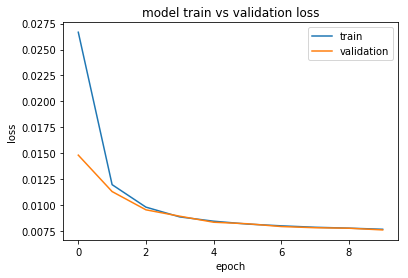

In [288]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [297]:
emb.save('embedding.h5')

In [289]:
X_ex = np.array([['Jeanne', 'aime', 'Marie'],
                 ['Jeanne', 'voit', 'Marie'],
                ['Pierre', 'tweetait', 'un', 'message'],
                ['Suzanne', 'googlera', 'la', 'réponse'],
                ['Anne',  'est', 'fatiguée']])
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)
test_prediction = emb.predict(X_ex_ci)

In [290]:
print(test_prediction[0])

[  1.87218748e-19   1.79852937e-19   1.37784961e-19   1.43106951e-21
   2.96302027e-36   2.52933763e-19   1.11227242e-19   3.54795239e-19
   1.78387637e-15   4.74478813e-19   2.83924062e-31   8.87555185e-29
   1.33828815e-19   4.16394113e-19   1.61159469e-19   5.21083111e-27
   2.06637847e-19   1.77128062e-19   1.23971769e-19   1.24884536e-19
   1.17178612e-19   3.21450374e-19   1.62365227e-19   1.56932163e-19
   2.31350139e-19   3.04810162e-19   5.12935829e-20   1.73188391e-22
   2.96781961e-19   1.68969076e-19   2.89362169e-35   1.40200031e-19
   1.92352851e-19   9.96222138e-01   2.39087664e-19   1.18657146e-19
   1.69099964e-19   1.74917590e-19   1.23739494e-31   4.60134604e-21
   2.05887206e-19   1.71128180e-38   2.25758269e-19   9.99999881e-01
   6.64751162e-20   6.01151330e-26   0.00000000e+00   0.00000000e+00
   7.31268504e-19   1.29968880e-19   1.88377137e-34   9.70582195e-19
   9.47892113e-20   2.28876481e-19   2.07679383e-19   3.51625037e-33
   3.14481092e-19   1.77567140e-19

In [291]:
def display_pred(X_ex, test_prediction, minprob):
    word_counter = 0
    # iterate over sentences
    for i in range(len(X_ex)):
        # iterate over words
        for j in range(len(X_ex[i])):
            print(X_ex[i][j], end = ': ')
            # iterate over word features
            for k in range(len(test_prediction[word_counter])):
                if test_prediction[word_counter][k] > minprob:
                    print(integer_to_feature[k], end = ' ')
            print('')
            word_counter = word_counter + 1



In [292]:
categories = set(['v', 'n', 'nc', 'adj'])
tenses = set(['S', 'P', 'K', 'J', 'T', 'F', 'C', 'I', 'Y', 'G', 'W'])
person = set(['1', '2', '3'])
numer = set(['s', 'p'])
gender = set(['m', 'f'])

def best_inflection(feats, tenses, feature_to_integer, beta):

    maxp = 0
    maxinfl = None
    for t in tenses:
        tnum = feature_to_integer[t]
        prob = feats[tnum]
        if prob > maxp:
            maxp = prob
            maxinfl = t
    cutoff = maxp * beta
    result = {}
    for t in tenses:
        tnum = feature_to_integer[t]
        prob = feats[tnum]
        if prob > cutoff:
             result[t] = prob
    return maxinfl, result

In [295]:
display_pred(X_ex, test_prediction, 0.5)

Jeanne: np hum f s 
aime: Y P 1 S imperative v 2 pers nc Obj:sn s 3 
Marie: np hum f s 
Jeanne: np hum f s 
voit: P v pers Obj:sn s 3 
Marie: np hum f s 
Pierre: m nc s 
tweetait: v pers Obj:sn s 3 
un: cf m pron pro det nc pseudo-en s 
message: m nc s 
Suzanne: f nc s 
googlera: v pers Obj:sn s 3 
la: cla f m det nc s 3 
réponse: f nc s 
Anne: f nc s 
est: adj P v m AttSuj pers nc s 3 
fatiguée: Obl2:(par-sn) adj active v f passive pers K Obj:sn s 


In [296]:
best_inflection(test_prediction[0][1], tenses, feature_to_integer, 0.1)

IndexError: invalid index to scalar variable.